#### Import libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


#### Load Data

In [3]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# shuffle the data
df=pd.read_csv("..\multilabelledDF_duplicates_removed_filename_latest.csv")
index = df.index
df = shuffle(df)
df.index = index


columns=["beautiful", "boring", "depressing", "lively", "safety", "wealthy"]

datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

batch_size = 16
image_size = 224

# train val test split = 10% test, 90% train val - 80% train, 20% val 
train_generator=datagen.flow_from_dataframe(
    dataframe=df[:8024],
    directory="../Download_GSV_Multilabelled",
    x_col="filename",
    y_col=columns,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(image_size,image_size))

valid_generator=datagen.flow_from_dataframe(
    dataframe=df[8025:10030],
    directory="../Download_GSV_Multilabelled",
    x_col="filename",
    y_col=columns,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(image_size,image_size))

test_generator=datagen.flow_from_dataframe(
    dataframe=df[10031:],
    directory="../Download_GSV_Multilabelled",
    x_col="filename",
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode=None,
    target_size=(image_size,image_size))

C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 8022 validated image filenames.
Found 2005 validated image filenames.
Found 1115 validated image filenames.


#### Building Keras VGG16 Model with Places365 Weights

In [4]:
# -*- coding: utf-8 -*-
'''VGG16-places365 model for Keras
# Reference:
- [Places: A 10 million Image Database for Scene Recognition](http://places2.csail.mit.edu/PAMI_places.pdf)
'''

from __future__ import division, print_function
import os

import warnings
import numpy as np

from keras import backend as K
from keras.layers import Input
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.layers import Conv2D
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16_Places365(include_top=True, weights='places',
                    input_tensor=None, input_shape=None,
                    pooling=None,
                    classes=365):
    """Instantiates the VGG16-places365 architecture.
    Optionally loads weights pre-trained
    on Places. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization),
                 'places' (pre-training on Places),
                 or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`, or invalid input shape
        """
    if not (weights in {'places', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `places` '
                         '(pre-training on Places), '
                         'or the path to the weights file to be loaded.')

    if weights == 'places' and include_top and classes != 365:
        raise ValueError('If using `weights` as places with `include_top`'
                         ' as true, `classes` should be 365')


    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten =include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Block 1
    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block1_conv1')(img_input)

    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block1_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool", padding='valid')(x)

    # Block 2
    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block2_conv1')(x)

    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block2_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool", padding='valid')(x)

    # Block 3
    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv1')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv2')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool", padding='valid')(x)

    # Block 4
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool", padding='valid')(x)

    # Block 5
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool", padding='valid')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dropout(0.5, name='drop_fc1')(x)

        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dropout(0.5, name='drop_fc2')(x)
        
        x = Dense(365, activation='softmax', name="predictions")(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, x, name='vgg16-places365')

    # load weights
    if weights == 'places':
        if include_top:
            weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')

        model.load_weights(weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')

    elif weights is not None:
        model.load_weights(weights)

    return model



#### Create Keras Model

In [5]:
from keras import optimizers
def create_model():
    
    model = VGG16_Places365(include_top = False, weights='places', pooling = "avg")
    
    # Freeze all layers except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False

    x = model.output
#     x = Dropout(0.4)(x)
    predictions = Dense(6, activation='sigmoid')(x)
    model = Model(inputs=model.input, outputs=predictions)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.001))
    
    return model

In [6]:
from sklearn.metrics import average_precision_score
from keras.callbacks import Callback
import cv2

class average_precision_score_callback(Callback):
    def __init__(self):

        self.mAP_train = []
        self.mAP_valid = []

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.train_precision_scores = []
        self.val_precision_scores = []
        directory = "../Download_GSV_Multilabelled"
        train_filenames = [directory + "/" + filename for filename in train_generator.filenames] 
        valid_filenames = [directory + "/" + filename for filename in valid_generator.filenames] 
        
        train_images = [cv2.imread(filename) for filename in train_filenames]
        valid_images = [cv2.imread(filename) for filename in valid_filenames]
        
        y_true = train_generator.labels
        for i in range(len(train_images)):
            y_pred = self.model.predict(train_images[i].reshape(1,224,224,3))            
            _average_precision_score = average_precision_score(y_true[i], y_pred[0])
            self.train_precision_scores.append(_average_precision_score)
        
        y_true_val = valid_generator.labels
        for i in range(len(valid_images)):
            y_pred_val = self.model.predict(valid_images[i].reshape(1,224,224,3))
            average_precision_score_val = average_precision_score(y_true_val[i], y_pred_val[0])
            self.val_precision_scores.append(average_precision_score_val)
        
        mAP_train = (sum(self.train_precision_scores))/(len(self.train_precision_scores))
        mAP_valid = (sum(self.val_precision_scores))/(len(self.val_precision_scores))
        self.mAP_train.append(mAP_train)
        self.mAP_valid.append(mAP_valid)
        print('mAP_train: {} - mAP_valid: {} \n'.format(str(mAP_train),str(mAP_valid)))
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [7]:
model = create_model()

print(model.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________

#### Train model

In [8]:
import wandb
from wandb.keras import WandbCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

wandb.init(project="sgd1701")

filepath="D:/FYP/modelPerformance7/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

average_precision_score_metrics = average_precision_score_callback()
numberOfEpochs = 500
history = model.fit_generator(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    epochs = numberOfEpochs,
                    callbacks = [average_precision_score_metrics, checkpoint, es, WandbCallback()],
                    validation_data = valid_generator,
                    validation_steps = valid_generator.samples // batch_size,
                    shuffle = True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 1/500
501/501 [==============================] - 160s 319ms/step - loss: 0.9217 - val_loss: 0.9331
mAP_train: 0.6933890828000671 - mAP_valid: 0.6934282349681375 


Epoch 00001: val_loss improved from inf to 0.93308, saving model to D:/FYP/modelPerformance7/weights-improvement-01-0.92.hdf5
Epoch 2/500
501/501 [==============================] - 77s 154ms/step - loss: 0.9200 - val_loss: 0.9138
mAP_train: 0.6935043907033337 - mAP_valid: 0.6945624826821855 


Epoch 00002: val_loss improved from 0.93308 to 0.91380, saving model to D:/FYP/modelPerformance7/weights-improvement-02-0.92.hdf5
Epoch 3/500
501/501 [==============================] - 76s 153ms/step - loss: 0.9190 - val_loss: 0.9267
mAP_train: 0.6933827806864358 - mAP_valid: 0.6955030479357183 


Epoch 00003: val_loss did not improve from 0.91380
Epoch 4/500
501/501 [==============================] - 77s 153ms/step - loss: 0.9185 - val_loss: 0.8844
mAP_train: 0.6940609850688281 - mAP_valid: 0.6951896647270734 


Epoch 00004: va


Epoch 00072: val_loss did not improve from 0.87463
Epoch 73/500
501/501 [==============================] - 78s 156ms/step - loss: 0.9059 - val_loss: 0.9562
mAP_train: 0.7017883459375496 - mAP_valid: 0.7001731781656997 


Epoch 00073: val_loss did not improve from 0.87463
Epoch 74/500
501/501 [==============================] - 78s 156ms/step - loss: 0.9066 - val_loss: 0.9194
mAP_train: 0.7019814607052717 - mAP_valid: 0.6997556109725718 


Epoch 00074: val_loss did not improve from 0.87463
Epoch 75/500
501/501 [==============================] - 78s 157ms/step - loss: 0.9063 - val_loss: 0.9207
mAP_train: 0.7019759550125926 - mAP_valid: 0.6995635910224466 


Epoch 00075: val_loss did not improve from 0.87463
Epoch 76/500
501/501 [==============================] - 78s 157ms/step - loss: 0.9064 - val_loss: 0.9055
mAP_train: 0.7012928682234859 - mAP_valid: 0.7002412025491858 


Epoch 00076: val_loss did not improve from 0.87463
Epoch 77/500
501/501 [==============================] - 78s 156m

501/501 [==============================] - 80s 159ms/step - loss: 0.9026 - val_loss: 0.9344
mAP_train: 0.704041005290994 - mAP_valid: 0.7020846494873964 


Epoch 00110: val_loss did not improve from 0.87463
Epoch 111/500
501/501 [==============================] - 79s 159ms/step - loss: 0.9027 - val_loss: 0.8931
mAP_train: 0.7044743967976843 - mAP_valid: 0.7011827376004468 


Epoch 00111: val_loss did not improve from 0.87463
Epoch 112/500
501/501 [==============================] - 80s 160ms/step - loss: 0.9029 - val_loss: 0.8492
mAP_train: 0.7041115058588769 - mAP_valid: 0.7020576336935472 


Epoch 00112: val_loss improved from 0.87463 to 0.84921, saving model to D:/FYP/modelPerformance7/weights-improvement-112-0.90.hdf5
Epoch 113/500
501/501 [==============================] - 78s 155ms/step - loss: 0.9023 - val_loss: 0.9062
mAP_train: 0.7039796808775739 - mAP_valid: 0.7021511499030236 


Epoch 00113: val_loss did not improve from 0.84921
Epoch 114/500
501/501 [========================


Epoch 00146: val_loss did not improve from 0.84921
Epoch 147/500
501/501 [==============================] - 79s 157ms/step - loss: 0.8987 - val_loss: 0.9123
mAP_train: 0.7066196778303997 - mAP_valid: 0.7024368246051566 


Epoch 00147: val_loss did not improve from 0.84921
Epoch 148/500
501/501 [==============================] - 78s 156ms/step - loss: 0.8999 - val_loss: 0.9137
mAP_train: 0.7066773664090314 - mAP_valid: 0.7027956497644812 


Epoch 00148: val_loss did not improve from 0.84921
Epoch 149/500
501/501 [==============================] - 79s 158ms/step - loss: 0.8998 - val_loss: 0.9111
mAP_train: 0.7070310119393781 - mAP_valid: 0.7026774729842095 


Epoch 00149: val_loss did not improve from 0.84921
Epoch 150/500
501/501 [==============================] - 79s 158ms/step - loss: 0.8979 - val_loss: 0.8926
mAP_train: 0.7065249037369348 - mAP_valid: 0.7026461623718512 


Epoch 00150: val_loss did not improve from 0.84921
Epoch 151/500
501/501 [==============================] - 79s


Epoch 00183: val_loss did not improve from 0.84921
Epoch 184/500
501/501 [==============================] - 82s 163ms/step - loss: 0.8962 - val_loss: 0.9238
mAP_train: 0.7096372475691756 - mAP_valid: 0.702839429204769 


Epoch 00184: val_loss did not improve from 0.84921
Epoch 185/500
501/501 [==============================] - 82s 164ms/step - loss: 0.8963 - val_loss: 0.9025
mAP_train: 0.709592925011764 - mAP_valid: 0.7024853144915522 


Epoch 00185: val_loss did not improve from 0.84921
Epoch 186/500
501/501 [==============================] - 82s 164ms/step - loss: 0.8944 - val_loss: 0.9140
mAP_train: 0.7103900385052118 - mAP_valid: 0.702907037960657 


Epoch 00186: val_loss did not improve from 0.84921
Epoch 187/500
501/501 [==============================] - 82s 164ms/step - loss: 0.8959 - val_loss: 0.9221
mAP_train: 0.7102407961439285 - mAP_valid: 0.7018344416735967 


Epoch 00187: val_loss did not improve from 0.84921
Epoch 188/500
501/501 [==============================] - 82s 16

#### Plot mAP and Loss

In [ ]:
from matplotlib import pyplot as plt

epochs = list(range(1,212+1))

plt.plot(epochs, average_precision_score_metrics.mAP_train)
plt.plot(epochs, average_precision_score_metrics.mAP_valid)
plt.title('Mean Average Precision')
plt.ylabel('mAP')
plt.xlabel('epoch')
plt.legend(['train mAP','validation mAP'], loc='upper left')
plt.show()

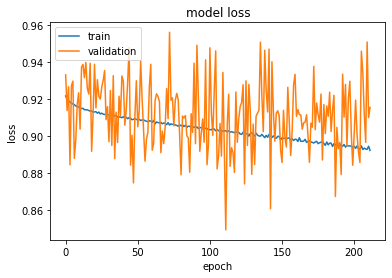

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

#### Save Model

In [13]:
from keras.models import load_model

model.save('places-1801_training.h5') 

#### Calculate Test mAP

In [14]:
y_true = df.as_matrix(columns=df.columns[5:])
y_true = y_true[10031:]
y_true

C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0, 0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 0]], dtype=int64)

In [15]:
import cv2
import numpy as np
import os
from sklearn.metrics import classification_report, average_precision_score, precision_score
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# classes = ["beautiful","boring","depressing","lively","safety","wealthy"]

precisionList = []

dir = r"D:\FYP\Download_GSV_Multilabelled"
imagePath = df.loc[df['Unnamed: 0'] > 10030]
imagePath = imagePath.loc[:,'filename'].values.tolist()
# print(imagePath)

for img in imagePath:
    path = os.path.join(dir, img)
    
    idx = imagePath.index(img)
    img = cv2.imread(path)
    
    y_scores = model.predict(img.reshape(1,224,224,3))
    precision = average_precision_score(y_true[idx], y_scores[0])
    print("predicted: {}".format(y_scores[0]))
    print("actual: {}".format(y_true[idx]))
    print("average precision: {}\n".format(precision))
    precisionList.append(precision)
    
print("mAP: ", sum(precisionList) / len(precisionList) )

predicted: [0.900 1.000 1.000 0.799 0.100 1.000]
actual: [0 0 0 1 1 0]
average precision: 0.26666666666666666

predicted: [0.996 1.000 0.245 0.864 0.001 0.017]
actual: [0 1 1 1 0 1]
average precision: 0.8041666666666667

predicted: [0.763 0.141 0.515 0.884 0.204 0.989]
actual: [0 0 1 1 1 1]
average precision: 0.8875

predicted: [0.264 0.990 0.569 0.037 0.000 1.000]
actual: [1 0 0 0 1 0]
average precision: 0.29166666666666663

predicted: [0.999 0.924 0.001 0.998 0.001 0.895]
actual: [1 1 1 1 1 0]
average precision: 0.9266666666666665

predicted: [1.000 0.005 0.002 1.000 0.492 1.000]
actual: [1 0 1 0 1 1]
average precision: 0.6458333333333333

predicted: [0.988 0.946 0.609 0.893 0.000 0.069]
actual: [0 1 1 0 1 1]
average precision: 0.5666666666666667

predicted: [0.984 0.416 0.809 0.960 0.275 0.523]
actual: [0 1 0 1 1 1]
average precision: 0.5666666666666667

predicted: [0.999 0.678 0.999 0.998 0.084 0.169]
actual: [0 0 1 0 0 0]
average precision: 1.0

predicted: [0.977 0.237 0.118 0.778

predicted: [0.999 1.000 0.948 0.051 0.054 0.001]
actual: [1 1 1 1 0 0]
average precision: 0.95

predicted: [0.001 0.988 0.602 0.028 0.000 0.000]
actual: [1 1 1 0 1 0]
average precision: 0.8541666666666666

predicted: [0.999 0.769 0.378 0.842 0.243 0.147]
actual: [0 0 0 0 0 1]
average precision: 0.16666666666666666

predicted: [0.976 0.117 0.020 0.364 0.050 0.098]
actual: [0 0 1 1 1 1]
average precision: 0.5666666666666667

predicted: [0.999 0.412 0.713 0.415 0.072 0.011]
actual: [1 0 0 0 0 1]
average precision: 0.6666666666666666

predicted: [0.563 0.087 0.153 0.439 0.840 0.318]
actual: [1 1 1 0 0 1]
average precision: 0.5666666666666667

predicted: [0.472 0.753 0.994 0.005 0.163 0.000]
actual: [1 0 0 0 1 1]
average precision: 0.4444444444444445

predicted: [0.953 0.230 0.030 0.774 0.001 1.000]
actual: [1 0 0 1 1 0]
average precision: 0.5555555555555556

predicted: [0.312 0.005 1.000 0.002 0.984 0.096]
actual: [1 1 1 0 0 0]
average precision: 0.7555555555555555

predicted: [0.985 0.068

predicted: [0.113 0.996 0.124 0.972 0.001 0.028]
actual: [1 0 1 0 1 1]
average precision: 0.525

predicted: [1.000 0.001 1.000 0.301 0.003 0.102]
actual: [1 1 0 0 0 1]
average precision: 0.5

predicted: [0.340 0.917 0.953 0.871 0.000 0.781]
actual: [0 0 1 0 0 0]
average precision: 1.0

predicted: [0.984 0.817 1.000 0.612 0.059 0.101]
actual: [0 0 1 0 1 0]
average precision: 0.6666666666666666

predicted: [0.953 0.230 0.030 0.774 0.001 1.000]
actual: [1 0 0 1 0 0]
average precision: 0.5833333333333333

predicted: [0.996 0.754 0.988 0.989 0.074 0.267]
actual: [0 1 1 0 0 0]
average precision: 0.41666666666666663

predicted: [0.967 0.743 0.939 0.488 0.125 0.327]
actual: [0 0 0 0 1 1]
average precision: 0.26666666666666666

predicted: [1.000 0.006 0.029 0.875 0.569 0.997]
actual: [1 0 0 0 0 0]
average precision: 1.0

predicted: [0.971 0.703 1.000 0.278 0.000 0.001]
actual: [1 1 1 0 1 1]
average precision: 0.9266666666666665

predicted: [0.010 0.828 0.996 0.386 0.067 0.005]
actual: [1 0 0 0 

predicted: [0.974 0.023 0.980 0.104 0.019 0.110]
actual: [0 0 0 1 1 1]
average precision: 0.4444444444444445

predicted: [0.994 0.559 0.992 0.621 0.086 0.001]
actual: [1 1 0 0 0 1]
average precision: 0.6666666666666667

predicted: [1.000 0.803 0.002 0.888 0.001 0.718]
actual: [0 0 0 0 0 1]
average precision: 0.25

predicted: [0.135 0.975 0.995 0.750 0.002 0.003]
actual: [0 1 0 0 1 0]
average precision: 0.41666666666666663

predicted: [0.729 0.005 0.008 0.999 0.513 1.000]
actual: [0 1 1 0 0 1]
average precision: 0.6333333333333333

predicted: [0.649 0.939 0.954 0.072 0.426 0.282]
actual: [0 1 1 0 0 0]
average precision: 1.0

predicted: [0.161 0.319 0.768 0.840 0.001 0.783]
actual: [0 1 1 0 0 1]
average precision: 0.6388888888888888

predicted: [0.994 0.861 0.987 0.967 0.113 0.165]
actual: [0 1 0 1 1 1]
average precision: 0.525

predicted: [1.000 0.866 0.918 0.806 0.250 0.934]
actual: [1 1 1 1 1 1]
average precision: 1.0

predicted: [0.952 1.000 0.997 0.573 0.000 0.030]
actual: [1 0 1 0 

predicted: [0.365 0.946 0.009 0.012 0.153 0.014]
actual: [1 1 0 1 1 0]
average precision: 0.95

predicted: [0.999 0.002 0.007 0.919 0.927 0.302]
actual: [0 1 0 0 1 0]
average precision: 0.41666666666666663

predicted: [0.387 1.000 0.998 0.993 0.000 0.000]
actual: [1 1 0 0 0 0]
average precision: 0.75

predicted: [1.000 0.856 0.018 0.997 0.005 0.978]
actual: [1 0 1 0 1 0]
average precision: 0.6333333333333333

predicted: [0.334 0.714 0.036 0.016 0.001 1.000]
actual: [1 1 0 1 1 1]
average precision: 0.9266666666666665

predicted: [0.993 0.017 0.999 0.763 0.978 0.012]
actual: [1 0 1 1 1 0]
average precision: 1.0

predicted: [0.442 1.000 0.002 0.884 0.121 0.692]
actual: [0 0 1 1 0 0]
average precision: 0.41666666666666663

predicted: [0.999 0.777 1.000 1.000 0.134 0.000]
actual: [0 1 0 0 0 1]
average precision: 0.29166666666666663

predicted: [0.891 0.911 0.990 0.394 0.013 0.001]
actual: [0 1 0 0 1 0]
average precision: 0.45

predicted: [0.834 0.003 0.995 0.286 0.705 0.972]
actual: [0 1 0 


predicted: [1.000 0.995 0.869 0.961 0.261 0.610]
actual: [0 0 0 1 1 0]
average precision: 0.3333333333333333

predicted: [0.996 0.597 0.973 0.534 0.069 0.000]
actual: [1 0 1 1 0 0]
average precision: 0.9166666666666665

predicted: [0.999 0.082 0.993 0.999 0.001 0.494]
actual: [0 0 1 1 1 1]
average precision: 0.7708333333333333

predicted: [0.111 0.160 0.997 0.848 0.041 0.639]
actual: [0 0 0 0 1 0]
average precision: 0.16666666666666666

predicted: [0.045 0.999 1.000 0.170 0.000 0.227]
actual: [0 1 1 1 0 0]
average precision: 0.9166666666666665

predicted: [0.247 0.875 0.424 0.001 0.000 1.000]
actual: [1 1 0 0 0 0]
average precision: 0.5

predicted: [1.000 0.998 0.999 0.989 0.001 0.042]
actual: [1 1 1 1 1 1]
average precision: 1.0

predicted: [0.940 1.000 1.000 0.116 0.001 0.026]
actual: [0 0 1 1 0 1]
average precision: 0.5333333333333333

predicted: [0.999 0.998 0.857 0.263 0.001 0.102]
actual: [1 0 1 1 0 1]
average precision: 0.8041666666666667

predicted: [1.000 0.027 0.001 0.999 0.

predicted: [0.919 0.996 0.649 0.067 0.022 0.145]
actual: [1 1 0 1 0 1]
average precision: 0.8875

predicted: [0.816 0.968 0.658 0.926 0.002 1.000]
actual: [0 1 1 1 1 0]
average precision: 0.6083333333333333

predicted: [0.976 0.203 0.836 0.144 0.201 0.004]
actual: [1 0 0 1 1 1]
average precision: 0.6916666666666667

predicted: [0.997 0.032 0.474 0.713 0.033 0.979]
actual: [0 1 1 1 1 1]
average precision: 0.71

predicted: [0.989 0.995 1.000 0.759 0.000 0.274]
actual: [0 1 1 1 1 0]
average precision: 0.8541666666666666

predicted: [0.899 0.996 0.778 0.015 0.978 0.955]
actual: [1 1 0 0 0 0]
average precision: 0.75

predicted: [1.000 0.854 1.000 0.990 0.047 0.257]
actual: [1 1 0 1 0 0]
average precision: 0.6388888888888888

predicted: [0.999 0.002 0.023 0.289 0.885 0.990]
actual: [0 1 0 1 0 1]
average precision: 0.5

predicted: [0.968 0.993 0.206 0.812 0.004 0.125]
actual: [0 0 1 1 1 1]
average precision: 0.525

predicted: [1.000 0.714 0.905 0.982 0.198 0.590]
actual: [0 0 1 0 1 1]
average

predicted: [0.559 0.965 0.547 0.781 0.004 0.795]
actual: [0 1 0 1 1 0]
average precision: 0.7222222222222222

predicted: [0.641 0.673 1.000 0.590 0.000 0.000]
actual: [1 1 0 1 1 1]
average precision: 0.71

predicted: [0.996 0.066 0.851 0.978 0.007 0.376]
actual: [1 1 1 0 0 0]
average precision: 0.7555555555555555

predicted: [0.939 0.971 0.998 0.903 0.010 0.103]
actual: [0 1 1 0 0 0]
average precision: 1.0

predicted: [0.296 0.532 0.947 0.013 0.024 0.003]
actual: [0 1 0 0 0 0]
average precision: 0.5

predicted: [0.418 0.000 0.970 0.945 0.222 0.110]
actual: [0 1 0 0 0 1]
average precision: 0.26666666666666666

predicted: [0.994 0.982 0.170 0.617 0.007 0.087]
actual: [0 0 1 0 1 1]
average precision: 0.38333333333333336

predicted: [0.954 0.272 0.002 0.972 0.754 0.979]
actual: [1 0 1 0 1 1]
average precision: 0.7708333333333333

predicted: [0.400 0.496 0.996 0.041 0.017 0.010]
actual: [1 1 1 0 1 0]
average precision: 0.95

predicted: [0.343 0.000 0.970 0.000 0.137 0.108]
actual: [0 0 0 1 

predicted: [0.084 0.004 0.742 0.014 0.660 0.001]
actual: [1 0 0 1 1 1]
average precision: 0.6458333333333333

predicted: [0.919 1.000 1.000 0.998 0.000 0.986]
actual: [0 0 1 0 0 1]
average precision: 0.75

predicted: [0.993 1.000 0.976 0.982 0.000 0.000]
actual: [0 1 1 1 1 0]
average precision: 0.8041666666666667

predicted: [0.152 1.000 0.878 0.958 0.000 1.000]
actual: [1 1 1 1 0 0]
average precision: 0.6791666666666667

predicted: [0.802 1.000 0.896 0.000 0.002 0.000]
actual: [0 1 0 1 1 0]
average precision: 0.7

predicted: [0.004 0.992 0.998 0.942 0.000 0.180]
actual: [1 1 1 1 0 1]
average precision: 1.0

predicted: [0.990 0.005 0.007 0.991 0.710 1.000]
actual: [0 0 1 1 0 1]
average precision: 0.8666666666666667

predicted: [0.999 0.248 1.000 0.963 0.927 0.465]
actual: [0 1 1 1 0 1]
average precision: 0.7333333333333333

predicted: [0.992 0.635 0.091 0.077 0.000 1.000]
actual: [1 1 1 1 1 1]
average precision: 1.0

predicted: [1.000 0.714 0.001 0.992 0.091 0.998]
actual: [0 1 0 1 1 1

predicted: [0.789 0.294 0.916 0.300 0.008 0.013]
actual: [1 1 1 0 0 0]
average precision: 0.9166666666666665

predicted: [0.759 0.002 0.999 0.891 0.003 0.926]
actual: [1 1 1 1 0 1]
average precision: 0.9666666666666666

predicted: [0.165 1.000 0.991 0.398 0.000 0.039]
actual: [0 0 1 1 0 0]
average precision: 0.5833333333333333

predicted: [0.000 0.082 0.955 0.000 0.137 0.989]
actual: [0 1 1 0 0 1]
average precision: 0.9166666666666665

predicted: [0.672 1.000 0.848 0.633 0.000 0.000]
actual: [0 1 1 1 0 0]
average precision: 0.9166666666666665

predicted: [0.832 0.994 1.000 0.995 0.000 0.001]
actual: [1 1 1 1 1 0]
average precision: 0.9666666666666666

predicted: [1.000 0.001 0.013 0.682 0.789 0.997]
actual: [0 0 1 1 1 0]
average precision: 0.4777777777777778

predicted: [0.152 1.000 0.878 0.958 0.000 1.000]
actual: [1 0 0 1 1 1]
average precision: 0.7333333333333333

predicted: [0.841 0.753 0.016 0.024 0.021 0.220]
actual: [1 0 0 0 1 1]
average precision: 0.7555555555555555

predicted:

predicted: [0.648 0.006 0.999 0.827 0.050 0.003]
actual: [0 0 0 1 1 0]
average precision: 0.5

predicted: [0.979 0.058 0.847 0.232 0.321 0.974]
actual: [0 1 0 1 1 0]
average precision: 0.38333333333333336

predicted: [0.322 1.000 0.913 0.998 0.000 0.937]
actual: [1 0 1 0 1 1]
average precision: 0.525

predicted: [0.135 0.975 0.995 0.750 0.002 0.003]
actual: [1 0 1 1 1 1]
average precision: 0.81

predicted: [0.199 0.970 0.898 0.014 0.307 0.146]
actual: [1 0 0 1 1 1]
average precision: 0.525

predicted: [0.996 1.000 0.998 0.982 0.000 0.149]
actual: [0 1 1 1 0 0]
average precision: 0.9166666666666665

predicted: [0.998 0.998 0.026 0.000 0.299 0.000]
actual: [0 0 0 0 1 1]
average precision: 0.3333333333333333

predicted: [0.015 0.925 0.752 0.009 0.000 0.984]
actual: [0 1 0 1 1 1]
average precision: 0.8166666666666667

predicted: [0.329 0.999 0.220 0.001 0.050 0.998]
actual: [1 1 0 0 1 0]
average precision: 0.7555555555555555

predicted: [1.000 0.839 0.405 0.982 0.147 0.005]
actual: [1 1 1 

predicted: [0.100 0.997 0.992 0.161 0.002 0.000]
actual: [1 0 1 0 0 1]
average precision: 0.5

predicted: [0.985 0.963 0.992 1.000 0.000 0.078]
actual: [1 1 1 0 0 1]
average precision: 0.6791666666666667

predicted: [0.099 0.804 0.991 0.001 0.050 0.024]
actual: [1 0 1 0 0 0]
average precision: 0.8333333333333333

predicted: [0.999 0.002 0.014 0.980 0.211 0.952]
actual: [1 0 0 0 1 1]
average precision: 0.8055555555555556

predicted: [1.000 0.997 0.996 0.794 0.005 0.804]
actual: [1 1 1 0 1 1]
average precision: 0.9666666666666666

predicted: [0.976 0.591 0.913 0.017 0.001 0.015]
actual: [0 0 0 0 1 0]
average precision: 0.16666666666666666

predicted: [0.999 0.268 0.220 0.993 0.106 0.999]
actual: [1 1 1 0 1 0]
average precision: 0.5666666666666667

predicted: [0.035 0.947 0.996 0.739 0.000 0.957]
actual: [1 0 0 1 1 1]
average precision: 0.5666666666666667

predicted: [0.396 0.006 0.695 0.202 0.539 0.082]
actual: [1 1 1 1 1 1]
average precision: 1.0

predicted: [0.994 0.994 0.991 0.656 0.0

predicted: [0.569 1.000 1.000 0.000 0.000 0.013]
actual: [0 1 1 1 0 0]
average precision: 0.8666666666666667

predicted: [0.757 0.981 0.985 0.297 0.024 0.004]
actual: [0 0 1 1 1 1]
average precision: 0.6916666666666667

predicted: [0.978 0.997 0.122 0.967 0.000 0.998]
actual: [1 1 1 1 1 1]
average precision: 1.0

predicted: [0.994 1.000 0.993 0.938 0.001 0.924]
actual: [1 1 1 1 1 0]
average precision: 0.9666666666666666

predicted: [1.000 0.976 0.848 0.229 0.002 0.250]
actual: [0 0 1 0 0 1]
average precision: 0.41666666666666663

predicted: [0.093 0.994 0.028 0.046 0.036 0.952]
actual: [0 1 1 1 1 1]
average precision: 0.8766666666666667

predicted: [1.000 1.000 0.991 0.878 0.052 0.000]
actual: [0 0 1 0 1 0]
average precision: 0.3666666666666667

predicted: [0.012 0.867 0.026 0.001 0.000 0.653]
actual: [0 0 1 1 1 0]
average precision: 0.41111111111111115

predicted: [1.000 0.984 0.064 0.753 0.417 0.000]
actual: [1 0 0 1 1 0]
average precision: 0.8055555555555556

predicted: [0.688 0.997

predicted: [0.926 0.008 0.060 0.996 0.132 0.995]
actual: [1 1 1 0 1 0]
average precision: 0.525

predicted: [0.346 0.885 1.000 0.008 0.005 0.025]
actual: [1 0 1 1 1 0]
average precision: 0.7333333333333333

predicted: [0.857 0.351 0.976 0.780 0.007 0.995]
actual: [1 1 0 0 0 1]
average precision: 0.7555555555555555

predicted: [0.996 0.980 0.997 0.442 0.004 0.000]
actual: [0 0 1 1 0 1]
average precision: 0.6666666666666667

predicted: [0.979 0.496 0.209 0.800 0.391 0.989]
actual: [0 1 1 0 1 1]
average precision: 0.6916666666666667

predicted: [1.000 0.011 0.036 1.000 0.199 0.796]
actual: [0 1 0 1 0 0]
average precision: 0.6666666666666666

predicted: [1.000 0.631 0.204 0.974 0.104 0.813]
actual: [0 1 1 1 1 0]
average precision: 0.5666666666666667

predicted: [1.000 0.982 1.000 0.991 0.699 0.002]
actual: [1 1 0 1 0 0]
average precision: 0.6388888888888888

predicted: [0.980 0.790 0.015 0.995 0.003 0.956]
actual: [1 1 0 1 1 0]
average precision: 0.8541666666666666

predicted: [0.896 0.992

predicted: [0.999 0.987 0.208 0.064 0.009 0.022]
actual: [1 1 1 1 1 0]
average precision: 0.9666666666666666

mAP:  0.6945201793721986
